In [9]:
# PU ExtraTree - A DT Classifier for PU Learning
import numpy as np
import scipy.stats
import scipy.sparse

class PUExtraTree:
    def __init__(self, risk_estimator = "nnPU",
                 loss = "quadratic",
                 max_depth = None,
                 min_samples_leaf = 1,
                 max_features = "sqrt",
                 max_candidates = 1):

        """

        Parameters
        ----------
        risk_estimator : {"PN", "uPU", "nnPU"}, default='nnPU'
            PU data based risk estimator. Supports supervised (PN) learning, unbiased PU (uPU) learning and nonnegative PU (nnPU) learning.
        loss : {"quadratic", "logistic"}, default='quadratic'
            The function to measure the cost of making an incorrect prediction. Supported loss functions are:
            "quadratic" l(v,y) = (1-vy)^2 and
            "logistic" l(v,y) = ln(1+exp(-vy)).
        max_depth : int or None, default=None
            The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_leaf samples.
        min_samples_leaf : int, default=1
            The minimum number of samples required to be at a leaf node. The default is 1.
        max_features : int or {"sqrt", "all"}, default="sqrt"
            The number of features to consider when looking for the best split. If "sqrt", then max_features = ceil(sqrt(n_features)). If "all", then max_features = n_features.
        max_candidates : int, default=1
            Number of randomly chosen split points to consider for each candidate feature.

        Returns
        -------
        None.

        """

        self.risk_estimator = risk_estimator
        self.loss = loss
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.max_candidates = max_candidates

        self.is_trained = False # indicate if tree empty/trained
        self.leaf_count = 0
        self.current_max_depth = 0
        self.nodes = {(0,0): {'data': None, 'j': None, 'xi': None, 'g': None,
                              'is_leaf': None, 'risk_reduction': None}}


    def create_successor(self, node, side):
        """
        Create an empty child node (either T or F) in the tree.
        Parameters
        ----------
        node : tuple of length 2.
            The parent node. First element is the depth in the tree, second element is the position at that depth.
        side : {"T", "F"} or {"L", "R"}
            Whether the node corresponds to a True or False split.
        Returns
        -------
        None.

        """

        row, column = node
        if side in ['T','L']:
            self.nodes[(row+1, 2*column)] = {'data': None, 'j': None,
                                                   'xi': None, 'g': None,
                                                   'is_leaf': None, 'loss': None,
                                                   'risk_reduction': None}
        elif side in ['F','R']:
            self.nodes[(row+1, 2*column+1)] = {'data': None, 'j': None,
                                                     'xi': None, 'g': None,
                                                     'is_leaf': None, 'loss': None,
                                                     'risk_reduction': None}
        elif side not in ['T','F','L','R']:
            print('choose valid position of child node: \'L\', \'R\', \'T\', \'F\'')



    def get_parent(self, node, return_truth_val):
        """
        Return parent node, and optionally the relationship to child node (T/F).

        Parameters
        ----------
        node : tuple of length 2
            The child node.
        return_truth_val : bool
            Indicate whether the truth value should also be returned, that is, whether the child node corresponds to a true or false split.
        Returns
        -------
        tuple of length 2 or (tuple of length 2, bool)
            The parent node, optionally the relationships to the parent nodes.

        """

        parent = (node[0] - 1, node[1] // 2)
        if return_truth_val:
            if node[1] % 2 == 0:
                return parent, True
            else:
                return parent, False
        else:
            return parent



    def get_ancestory(self, node):
        """
        Get parent nodes and relationship to the child nodes all the way to the root.

        Parameters
        ----------
        node : tuple of length 2
            Child node.

        Returns
        -------
        list
            List of nodes.
        bools : list
            List of bools with the relationships to the parents.

        """
        chain = [node]
        bools = []
        while chain[-1] != (0,0):
            parent, relationship = self.get_parent(chain[-1], True)
            chain += [parent]
            bools += [relationship]

        return chain[1:], bools


    def load_tree(self, nodes):
        """
        Load saved tree.

        Parameters
        ----------
        nodes : dictionary
            Dictionary describing the trained decision tree. Typically output from self.nodes.

        Returns
        -------
        None.

        """

        self.nodes = nodes
        self.is_trained = True




    def fit(self, pi, P = None, U = None, N = None):
        """
        Fit the decision tree.

        Parameters
        ----------
        pi : float
            Prior probability that an example belongs to the positive class.
        P : array-like of shape (n_p, n_features), default=None
            Training samples from the positive class.
        U : array-like of shape (n_u, n_features), default=None
            Unlabeled training samples.
        N : array-like of shape (n_n, n_features), default=None
            Training samples from the negative class if performing PN learning.

        Returns
        -------
        self
            Returns instance of self.

        """
        if self.risk_estimator in ['uPU', 'nnPU']:
            X = np.concatenate((P, U), axis = 0)
            y = np.concatenate((np.ones(len(P)), np.zeros(len(U))))
        elif self.risk_estimator in ['PN']:
            X = np.concatenate((P, N), axis = 0)
            y = np.concatenate((np.ones(len(P)), -np.ones(len(N))))

        # X = X.astype(np.float32)
        y = y.astype(np.int8).flatten()
        n, self.d = X.shape
        n_p = (y == 1).sum()
        n_u = (y == 0).sum()
        n_n = (y == -1).sum()
        self.pi = pi

        if self.pi is None:
            print('please specify pi')

        if self.max_features == 'sqrt':
            self.max_features = int(np.ceil(np.sqrt(X.shape[1])))
        elif self.max_features == 'all':
            self.max_features = X.shape[1]
        elif self.max_features in [i for i in range(1, self.d+1)]:
            None
        else:
            print('select valid number of max features to consider splitting on.')
            return None


        self.nodes[(0,0)]['data'] = scipy.sparse.coo_matrix(np.ones(n).astype(bool))

        def data_at_node(node):
            # return subset of training data in partition specified by certain node

            if self.nodes[node]['data'] is not None:
                return self.nodes[node]['data'].toarray()[0]
            else:
                # get indices of data at parent
                parent_node, relationship = self.get_parent(node, True)
                ind_parent = self.nodes[parent_node]['data'].toarray()[0].copy()
                checks = (X[ind_parent, self.nodes[parent_node]['j']] <= self.nodes[parent_node]['xi']) == relationship
                ind_parent[ind_parent] = checks.flatten()
                self.nodes[node]['data'] = scipy.sparse.coo_matrix(ind_parent)
                return ind_parent


        def impurity_node(y_sigma):
            # impurity of single node
            if self.risk_estimator in ["uPU", "nnPU"]:
                Wp = (y_sigma == 1).sum() * self.pi/n_p
                Wn = (y_sigma == 0).sum()/n_u - Wp

                if Wp + Wn == 0:
                    vstar = float('inf')
                else:
                    vstar = Wp/(Wp + Wn)

            elif self.risk_estimator in ['PN']:
                Wp = (y_sigma == 1).sum() * self.pi/n_p
                Wn = (y_sigma == -1).sum() * (1-self.pi)/n_n

                if Wp + Wn == 0:
                    vstar = float('inf')
                else:
                    vstar = Wp/(Wp + Wn)


            if self.loss == "quadratic":
                if self.risk_estimator == "uPU" and vstar == float('inf'):
                    return -float('inf')
                elif self.risk_estimator == "nnPU" and vstar > 1:
                    return 0
                else:
                    return 4 * (Wp + Wn) * vstar * (1 - vstar)

            elif self.loss == "logistic":
                if self.risk_estimator == "uPU" and vstar > 1:
                    return -float('inf')
                elif self.risk_estimator in ["uPU", "nnPU", "PN"] and vstar in [0,1]:
                    return 0
                elif self.risk_estimator == "nnPU" and vstar > 1:
                    return 0
                else:
                    return (Wp + Wn) * (-vstar*np.log(vstar) - (1-vstar)*np.log(1-vstar))


        def impurity_split(sigma, j, xi):
            mask = (X[sigma, j] <= xi).flatten()
            imT = impurity_node(y[sigma][mask])
            imF = impurity_node(y[sigma][~mask])
            return imT + imF


        def regional_prediction_function(y_sigma):
            if self.risk_estimator in ["uPU", "nnPU"]:
                Wp = (y_sigma == 1).sum() * self.pi/n_p
                Wn = (y_sigma == 0).sum()/n_u - Wp

                if Wp + Wn == 0:
                    vstar = float('inf')
                else:
                    vstar = Wp/(Wp + Wn)

            elif self.risk_estimator in ["PN"]:
                Wp = (y_sigma == 1).sum() * self.pi/n_p
                Wn = (y_sigma == -1).sum() * (1-self.pi)/n_n

                if Wp + Wn == 0:
                    vstar = float('inf')
                else:
                    vstar = Wp/(Wp + Wn)

            if vstar > 0.5:
                return 1
            elif vstar < 0.5:
                return -1
            elif vstar == 0.5:
                return 2*np.random.binomial(1,0.5)-1


        def construct_subtree(node, sigma):
            # first check stopping criteria
            impurity = impurity_node(y[sigma])

            # check node pure
            if self.risk_estimator in ['nnPU', 'PN']:
                c1 = impurity > 0
            elif self.risk_estimator == 'uPU':
                if y[sigma].sum() == 0:
                    c1 = impurity > 0
                else:
                    c1 = impurity > -float('inf')

            # check max depth reached
            if self.max_depth is None:
                c2 = True
            else:
                c2 = node[0] < self.max_depth # max depth reached
            c3 = self.min_samples_leaf < sigma.sum() # minimum samples in node reached
            att_ptp = np.ptp(X[sigma], axis = 0)
            c4 = att_ptp.sum() > 0 # check if there is any variability in features
            # c4 = np.unique(X[sigma], axis = 0).shape[0] > 1
            # check if any of the criteria satisfied
            # if so, turn into a leaf node
            if c1*c2*c3*c4 == 0:
                self.nodes[node]['is_leaf'] = True
                lab = regional_prediction_function(y[sigma])
                self.nodes[node]['g'] = lab
                self.nodes[node]['risk_reduction'] = 0
                self.leaf_count += 1
            else:
                self.nodes[node]['is_leaf'] = False
                # find valid nodes that can be used for a split
                atts = []
                for i in range(self.d):
                    if att_ptp[i] > 0:
                        atts += [i]

                # ranomly pick candiates attributes
                attributes = np.random.choice(atts, size = min(self.max_features, len(atts)), replace = False)
                candidates = []
                candidate_attributes = []
                candidate_cut_points = []
                for i in range(len(attributes)):
                    for j in range(self.max_candidates):
                        # need to guard against errors caused by finite precision
                        a_,b_,c_,d_ = np.unique(X[sigma, attributes[i]])[[0,1,-2,-1]]
                        cut_point = np.random.uniform(a_ + 2*(b_-a_)/5, c_ + 3*(d_-c_)/5)
                        candidates += [[attributes[i], cut_point]]
                        candidate_attributes += [attributes[i]]
                        candidate_cut_points += [cut_point]

                impurities = []
                for i in range(len(candidates)):
                    impurities += [impurity_split(sigma, candidate_attributes[i], candidate_cut_points[i])]

                minimiser = np.argmin(impurities)
                best_attribute = candidate_attributes[minimiser]
                best_cut_point = candidate_cut_points[minimiser]

                self.nodes[node]['j'] = int(best_attribute)
                self.nodes[node]['xi'] = best_cut_point
                self.nodes[node]['risk_reduction'] = impurity - impurities[minimiser]

                # create successors of current node
                self.create_successor(node, 'T')
                self.create_successor(node, 'F')

                # get set of data in these successors
                succs = ((node[0]+1, 2*node[1]), (node[0]+1, 2*node[1]+1))
                sigma_T = data_at_node(succs[0])
                sigma_F = data_at_node(succs[1])

                #keep tabs on how training is going
                # if node[0] > self.current_max_depth:
                    # self.current_max_depth = node[0]
                    # if self.current_max_depth % 30 == 0:
                    #     if self.current_max_depth > 1:
                    #         print('current max depth', self.current_max_depth)
                # print('current max depth', self.current_max_depth)

                # construct_subtree on the sucessors
                construct_subtree(succs[0], sigma_T)
                construct_subtree(succs[1], sigma_F)

        # train the dt
        construct_subtree((0,0), np.ones(n).astype(bool))
        self.is_trained = True
        return self


    def predict(self, X):
        """
        Predict classes for examples in X.
        The predicted class of an input sample is the majority vote by the trees in the forest.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The test samples.

        Returns
        -------
        preds : array of shape (n_samples,)
            The predicted classes.

        """
        # first check to see if the tree is empty/trained
        if self.is_trained:

            preds = np.zeros(len(X)).astype(np.int8)
            for i in range(len(X)):
                X_ = X[i]
                a,b = 0,0
                tnode = self.nodes[(a,b)]
                while not tnode['is_leaf']:
                    check = X_[tnode['j']] <= tnode['xi']

                    if check:
                        b = 2*b
                    else:
                        b = 2*b + 1

                    a += 1
                    tnode = self.nodes[(a,b)]

                if tnode['is_leaf']:
                    preds[i] = tnode['g']

            return preds
        else:
            print('tree not finished training!')


    def n_leaves(self):
        """
        Get the number of leaf nodes in a tree (number of regions created in feature space).

        Returns
        -------
        temp : int
            Number of leaf nodes in the classifier.

        """
        return self.leaf_count

    def get_depth(self):
        """
        Return the depth of the decision tree. The depth of a tree is the maximum distance between the root and any leaf.

        Returns
        -------
        max_depth : int
            The maximum depth of the tree.

        """

        max_depth = -1
        for node in self.nodes.keys():
            if node[0] > max_depth:
                max_depth = node[0]
        return max_depth

    def feature_importances(self):
        """
        Compute the risk reduction feature importances.

        Returns
        -------
        impurities : array-like of shape (n_features,)
            Risk reduction feature importances.

        """

        impurities = np.zeros([self.d])
        for node in self.nodes:
            if self.nodes[node]['j'] is not None:
                impurities[self.nodes[node]['j']] += self.nodes[node]['risk_reduction']

        return impurities


In [10]:
!pip install joblib

In [14]:
# PU ExtraTrees - A Random Forest Classifier for PU Learning
# from tree import PUExtraTree
from joblib import Parallel, delayed
import scipy
import numpy as np

class PUExtraTrees:
    def __init__(self, n_estimators = 100,
                 risk_estimator = 'nnPU',
                 loss = 'quadratic',
                 max_depth = None,
                 min_samples_leaf = 1,
                 max_features = 'sqrt',
                 max_candidates = 1,
                 n_jobs = 1):
        """
        An extra-trees binary classifier that can be trained using only positive and unlabeled samples, or positive and negative samples.

        Parameters
        ----------
        risk_estimator : {"PN", "uPU", "nnPU"}, default='nnPU'
            PU data based risk estimator. Supports supervised (PN) learning, unbiased PU (uPU) learning and nonnegative PU (nnPU) learning.
        loss : {"quadratic", "logistic"}, default='quadratic'
            The function to measure the cost of making an incorrect prediction. Supported loss functions are:
            "quadratic" l(v,y) = (1-vy)^2 and
            "logistic" l(v,y) = ln(1+exp(-vy)).
        max_depth : int or None, default=None
            The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_leaf samples.
        min_samples_leaf : int, default=1
            The minimum number of samples required to be at a leaf node. The default is 1.
        max_features : int or {"sqrt", "all"}, default="sqrt"
            The number of features to consider when looking for the best split. If "sqrt", then max_features = ceil(sqrt(n_features)). If "all", then max_features = n_features.
        max_candidates : int, default=1
            Number of randomly chosen split points to consider for each candidate feature.
        n_jobs : int, default=1
            The number of jobs to run in parallel. fit and predict are all parallelized over the trees.

        Returns
        -------
        None.

        """

        self.n_estimators = n_estimators
        self.risk_estimator = risk_estimator
        self.loss = loss
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.max_candidates = max_candidates
        self.n_jobs = n_jobs

        self.leaf_count = 0
        self.current_max_depth = 0
        self.is_trained = False # indicate if tree empty/trained

    def train_tree(self, P = None, U = None, N = None, pi = None):
        """
        Train a single decision tree.

        Parameters
        ----------
        P : array-like of shape (n_p, n_features), default=None
            Training samples from the positive class.
        U : array-like of shape (n_u, n_features), default=None
            Unlabelled training samples.
        N : array-like of shape (n_n, n_features), default=None
            Training samples from the negative class if performing supervised (PN) learning.
        pi : float
            Prior probability that an example belongs to the positive class.

        Returns
        -------
        g : ET classifier
            An instance of the single tree RF classifier.

        """
        g = PUExtraTree(risk_estimator = self.risk_estimator,
                        loss = self.loss,
                        max_depth = self.max_depth,
                        min_samples_leaf = self.min_samples_leaf,
                        max_features = self.max_features,
                        max_candidates = self.max_candidates)
        g.fit(P = P, U = U, N = N, pi = pi)
        return g

    def predict_tree(self, g, X):
        """
        Predict classes for examples in X using the single DT g.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The test samples.

        Returns
        -------
        preds : array of shape (n_samples,)
            The predicted classes.

        """
        return g.predict(X)

    def fit(self, P = None, U = None, N = None, pi = None):
        """
        Train the random forest.

        Parameters
        ----------
        pi : float
            Prior probability that an example belongs to the positive class.
        P : array-like of shape (n_p, n_features), default=None
            Training samples from the positive class.
        U : array-like of shape (n_u, n_features), default=None
            Unlabeled training samples.
        N : array-like of shape (n_n, n_features), default=None
            Training samples from the negative class if performing PN learning.

        Returns
        -------
        self
            Returns instance of self.

        """
        self.gs = Parallel(n_jobs = min(self.n_jobs, self.n_estimators), prefer="threads")(delayed(self.train_tree)(P = P, U = U, N = N, pi = pi) for i in range(self.n_estimators))
        self.is_trained = True
        return self

    def predict(self, X):
        """
        Predict classes for examples in X.
        The predicted class of an input sample is the majority vote by the trees in the forest.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The test samples.

        Returns
        -------
        preds : array of shape (n_samples,)
            The predicted classes.

        """
        self.preds = Parallel(n_jobs = min(self.n_jobs, self.n_estimators), prefer="threads")(delayed(self.predict_tree)(g, X) for g in self.gs)
        return scipy.stats.mode(np.array(self.preds), axis = 0)[0]

    def n_leaves(self, tree):
        """
        Get the number of leaf nodes in a specified tree

        Parameters
        ----------
        tree : int
            The index of the tree.

        Returns
        -------
        Number of leaf nodes in the specified tree.

        """

        return self.gs[tree].n_leaves()

    def get_depth(self, tree):
        """
        Get the depth of a specified tree in the forest.

        Parameters
        ----------
        tree : int
            The index of the tree.

        Returns
        -------
        Depth of the specified tree.

        """

        return self.gs[tree].get_depth()

    def get_max_depth(self):
        """
        Return the depth of the deepest tree in the forest.

        Returns
        -------
        Maximum depth : int

        """

        depths = []
        for tree in self.gs:
            depths += [tree.get_depth()]
        return np.max(depths)

    def feature_importances(self):
        """
        Get the risk reduction feature importances.

        Returns
        -------
        importances : array of shape (n_features,)
            The risk reduction feature importances.

        """
        importances = np.zeros([self.gs[0].d])
        for tree in self.gs:
            importances += tree.feature_importances()/self.n_estimators

        return importances


In [15]:
from sklearn.metrics import f1_score, accuracy_score

Accuracy 0.9397
Number of leaves in 3rd tree of forest: 263
Maximum depth of any tree in forest: 25
Depth of the 3rd tree in forest 17


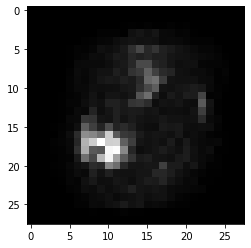

In [17]:
import numpy as np
from sklearn.datasets import fetch_openml
# from trees import PUExtraTrees
import matplotlib.pyplot as plt

# fetch mnist digits
X, y = fetch_openml('mnist_784', return_X_y = True, as_frame = False)
y = y.astype(np.int8)

# convert to binary labels
y[y % 2 == 1] = -1 # Odd digits form N class
y[y % 2 == 0] = 1 # Even digits form P class

pi = (y == 1).mean()
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

# construct P and U sets for training
n_p = 1000
positive_indices = np.random.choice(np.where(y_train == 1)[0], size = n_p, replace = False)
P = X_train[positive_indices]
U = X_train.copy()

g = PUExtraTrees(n_estimators = 100,
                 risk_estimator = 'nnPU',
                 loss = 'quadratic',
                 max_depth = None,
                 min_samples_leaf = 1,
                 max_features = 'sqrt',
                 max_candidates = 1,
                 n_jobs = 4)

g.fit(P=P, U=U, pi=pi)
predictions = g.predict(X_test)

print('Accuracy', (predictions == y_test).mean())

print('Number of leaves in 3rd tree of forest:', g.n_leaves(3-1))
print('Maximum depth of any tree in forest:', g.get_max_depth())
print('Depth of the 3rd tree in forest', g.get_depth(3-1))

importances = g.feature_importances()
plt.figure()
plt.imshow(importances.reshape(28,28), cmap = 'gray')
plt.show()

In [18]:
g1 = PUExtraTrees(n_estimators = 100,
                 risk_estimator = 'nnPU',
                 loss = 'logistic',
                 max_depth = None,
                 min_samples_leaf = 1,
                 max_features = 'sqrt',
                 max_candidates = 1,
                 n_jobs = 4)
g1.fit(P=P, U=U, pi = pi)
predictions = g1.predict(X_test)
print('Accuracy', (predictions == y_test).mean())

Accuracy 0.938


In [23]:
g2 = PUExtraTrees(n_estimators = 100,
                 risk_estimator = 'uPU',
                 loss = 'logistic',
                 max_depth = None,
                 min_samples_leaf = 1,
                 max_features = 'sqrt',
                 max_candidates = 1,
                 n_jobs = 4)
g2.fit(P=P, U=U, pi = pi)
predictions1 = g2.predict(X_test)
print('Accuracy', (predictions1 == y_test).mean())

Accuracy 0.9034


In [24]:
g3 = PUExtraTrees(n_estimators = 100,
                 risk_estimator = 'uPU',
                 loss = 'quadratic',
                 max_depth = None,
                 min_samples_leaf = 1,
                 max_features = 'sqrt',
                 max_candidates = 1,
                 n_jobs = 4)
g3.fit(P=P, U=U, pi = pi)
predictions3 = g3.predict(X_test)
print('Accuracy', (predictions3 == y_test).mean())

Accuracy 0.5074
